# Formation DSA - Fabien FAIVRE

**TD Antoine LY : analyse de sentiments**

L'objectif est de vous faire approfondir une notion de machine learning aux travers d'une compétition Kaggle. Kaggle est aujourd'hui un site de compétition incontournable dans le monde du machine learning. Même si la plateforme n'est pas représentative des enjeux opérationnels, elle est néanmoins représentative des sujets d'attention de la communauté scientifique et demeure un bon outil d'apprentissage est de partage.


Le projet consiste donc à utiliser le challenge [Tweet sentiment extraction](https://www.kaggle.com/c/tweet-sentiment-extraction/overview/description) à des fins académiques.


### Les données

Les données sont celles proposées par le challenge. Elles composent de deux fichiers:

* `train.csv` ce document comportent les données à utiliser pour calibrer votre modèle. Il comporte toutes les colonnes
* `test.csv` ce document n'est utilisé **que** pour évaluer la performance finale de votre modèle. En aucun cas il ne peut être utilisé pour fine-tuner ou calibrer votre modèle. Il simule les données qui ne sont normalement JAMAIS accessible sur Kaggle (ni dans la vraie vie). à considérer comme un nouvel échantillon.

### Le challenge

Prédire la colonne `sentiment` à partir de la colonne `text`.

### La métrique d'évaluation

On utilisera un score F1 à l'aide de la fonction implémentée dans `scikit-learn`

    from sklearn.metrics import f1_score
    y_true = [0, 1, 2, 0, 1, 2]
    y_pred = [0, 2, 1, 0, 0, 1]
    f1_score(y_true, y_pred, average='macro')


### Labels à utiliser pour la colonne `sentiment`

Vous devrez retraiter la colonne `sentiment` en utilisant les remplacements suivants:

    "neutral"  ->  0
    "negative" -> -1
    "positive" ->  1

### Informations pratiques sur le rendu et la notation.

L'objectif est de se familiariser avec les techniques de text-mining à des fins de classification de sentiments d'un texte. La notation se décomposera en deux parties:

#### Notation

* Votre méthodologie et votre approche (12 points) : cette partie doit mettre en avant la motivation des différents retraitements que vous avez appliquez, votre effort de comprendre les implémentations des pacakges que vous aurez utilisés ainsi que le bon sens que leurs utilisations transcrit.
* La performance finale et méthodologie (4 + 4 = 8 points) : cette notation sera relative au groupe. 3 tentatives d'algorithmes/preprocessing différents permettrons de garantir 4 points sur les 8. Les 3 premiers du classement (du groupe 2020) calculé à l'aide du score F1 sur la base de test atteigneront 4 points supplémentaires. Le reste du barême relatif au classement sera dégressif de façon linéaire par palier: les derniers obtenant 1 point minimum.

#### Rendu

Le rendu se fera sous la forme d'un court rapport (max 5 pages). Ce dernier peut se faire sous la forme d'un notebook (html ou pdf) ou d'un rapport traditionnel (word, pdf). Il doit mettre en avant la méthodologie employée, les difficultés rencontrées ainsi que les différents apprentissages.


Le projet sera à rendre lors de la séance de **Juillet 2021** de restitution.

### Language de programmation

Il est fortement recommandé d'effectuer le projet en python, mais ceci n'est pas obligatoire.

Bibliographie:

https://www.scor.com/fr/articles-experts/accroitre-vitesse-et-precision-grace-lexploration-de-texte-et-au-traitement

# Approche méthodologique

L'approche suivie est double. Elle a consisté à :
- prendre en main les approches de traitement du NLP en suivant la gradation historique (Bag of Words => TF-IdF => Word2Vec => DL avec notamment l'implémentation ` Twitter-roBERTa-base for Sentiment Analysis` sur [HuggingFace](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment).
- s'approprier des techniques de MLOps au travers de l'utilisation et de l'adaptation d'un instanciation particulière de cookiecutter par [Manifold.ai](https://github.com/manifoldai/orbyter-cookiecutter). Ce template permet d'instancier deux environnement dockerisés (l'un pour l'environnement de développement et l'autre pour un serveur ML_Flow). L'ensemble des travaux a été versionné dans ce [repo github](https://github.com/Fabien-DS/DSA_Sentiment). L'objectif de cette difficulté compélmentaire était de tester en situation réel un ensemble d'outillages potentiellement intéressants pour MACIF.

# INSPIRATION

https://towardsdatascience.com/sentiment-classification-in-python-da31833da01b

## 0) Création des prérequis

Cette section sert à mettre en place l'environnement de travail
- charger les packages nécessaires au projet
- permettre de refactoriser le code du projet sous forme de package
- mettre un place un tracking d'experiment avec ML_Flow pour suivre les itérations du projet

### Import des packages utilisés

In [1]:
#Temps et fichiers
import os
import warnings
import time
from datetime import timedelta

#Manipulation de données
import pandas as pd
import numpy as np

# Text
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
import string
import re
import spacy 


#Modélisation
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import LinearSVC
from sklearn.model_selection import RandomizedSearchCV# the keys can be accessed with final_pipeline.get_params().keys()
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier


#Evaluation
from sklearn.metrics import f1_score, confusion_matrix


#Visualisation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px


#Tracking d'expérience
import mlflow
import mlflow.sklearn

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


### Utilisation du code du projet packagé

In [2]:
#Cette cellule permet d'appeler la version packagée du projet et d'en assurer le reload avant appel des fonctions
%load_ext autoreload
%autoreload 2

In [3]:
from dsa_sentiment.scripts.make_dataset import load_data

In [4]:
from dsa_sentiment.scripts.evaluate import eval_metrics

In [5]:
from dsa_sentiment.scripts.make_dataset import Preprocess_StrLower, Preprocess_transform_target

### Configuration de l'experiment MLFlow

In [6]:
mlflow.tracking.get_tracking_uri()

'/mnt/experiments'

In [2]:
#Temps et fichiers
import os
import warnings
import time
from datetime import timedelta

#Manipulation de données
import pandas as pd
import numpy as np

# Text
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
import string
import re
import spacy 


#Modélisation
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import LinearSVC
from sklearn.model_selection import RandomizedSearchCV# the keys can be accessed with final_pipeline.get_params().keys()
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier


#Evaluation
from sklearn.metrics import f1_score, confusion_matrix


#Visualisation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px


#Tracking d'expérience
import mlflow
import mlflow.sklearn#Temps et fichiers
import os
import warnings
import time
from datetime import timedelta

#Manipulation de données
import pandas as pd
import numpy as np

# Text
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
import string
import re
import spacy 


#Modélisation
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import LinearSVC
from sklearn.model_selection import RandomizedSearchCV# the keys can be accessed with final_pipeline.get_params().keys()
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier


#Evaluation
from sklearn.metrics import f1_score, confusion_matrix


#Visualisation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px


#Tracking d'expérience
import mlflow
import mlflow.sklearn

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


ModuleNotFoundError: No module named 'textblob'

### Chargement des données

In [3]:
data_folder = os.path.join('..', 'data', 'raw')
all_raw_files = [os.path.join(data_folder, fname)
                    for fname in os.listdir(data_folder)]
all_raw_files

['../data/raw/sample_submission.csv',
 '../data/raw/test.csv',
 '../data/raw/train.csv']

random_state=42

Il n'est pas possible de faire de l'imputation comme avec des champs numérique. Il convient donc de supprimer les entrées vides

In [21]:
X_train, y_train, X_val, y_val = load_data(all_raw_files[2], split=True, test_size=0.3, random_state=random_state, dropNA=True)

In [22]:
X_train.head()

,textID,text,selected_text
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going"
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD
2,088c60f138,my boss is bullying me...,bullying me
3,9642c003ef,what interview! leave me alone,leave me alone
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,"


In [23]:
y_train.head()

,sentiment
0,neutral
1,negative
2,negative
3,negative
4,negative


In [2]:
print('le jeu d\'entraînement initial contient', X_train.shape[0] + X_val.shape[0], 'lignes')

NameError: name 'X_train' is not defined

In [25]:
X_test, y_test = load_data(all_raw_files[1], split=False, random_state=random_state, dropNA=True)

In [26]:
X_test.head()

,textID,text
0,f87dea47db,Last session of the day http://twitpic.com/67ezh
1,96d74cb729,Shanghai is also really exciting (precisely -...
2,eee518ae67,"Recession hit Veronique Branquinho, she has to..."
3,01082688c6,happy bday!
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!


In [27]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   textID  3534 non-null   object
 1   text    3534 non-null   object
dtypes: object(2)
memory usage: 55.3+ KB


In [28]:
y_test.head()

,sentiment
0,neutral
1,positive
2,negative
3,positive
4,positive


In [29]:
#X_train = Preprocess_StrLower(X_train, columns_to_process=['text'])
X_train.head()

,textID,text,selected_text
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going"
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD
2,088c60f138,my boss is bullying me...,bullying me
3,9642c003ef,what interview! leave me alone,leave me alone
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,"


In [30]:
y_train = Preprocess_transform_target(y_train, columns_to_process=['sentiment'])
y_train.head()

,sentiment
0,0
1,-1
2,-1
3,-1
4,-1


In [31]:
y_val = Preprocess_transform_target(y_val, ['sentiment'])
y_val.head()

,sentiment
19236,0
19237,-1
19238,1
19239,-1
19240,1


In [32]:
#X_test = Preprocess_StrLower(X_test, columns_to_process=['text'])
X_test.head()

,textID,text
0,f87dea47db,Last session of the day http://twitpic.com/67ezh
1,96d74cb729,Shanghai is also really exciting (precisely -...
2,eee518ae67,"Recession hit Veronique Branquinho, she has to..."
3,01082688c6,happy bday!
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!


In [33]:
y_test = Preprocess_transform_target(y_test, ['sentiment'])
y_test.head()

,sentiment
0,0
1,1
2,-1
3,1
4,1


## 1) Model

On commence par définir une fonction générique qui sera en capacité d'ajuster, optimiser et logger dans MLFlow les résultats de pipelines qui seront produits pour chaque essai

In [34]:
def trainPipelineMlFlow(xpName, pipeline, X_train, y_train, X_test, y_test, fixed_params={}, opti=False, iterable_params={}):
    """
    Fonction générique permettant d'entrainer et d'optimiser un pipeline sklearn
    Les paramètres et résultats sont stockés dans MLFlow
    """
  
    with mlflow.start_run(run_name=xpName):
        
        start_time = time.monotonic()  
        
        warnings.filterwarnings("ignore")
        
        # fit pipeline
        pipeline.set_params(**fixed_params)
        if not opti:
            search = pipeline
        else:
            search = RandomizedSearchCV(pipeline, iterable_params)
        search.fit(X_train, y_train)
                
        # get params
        # params_to_log = pipeline.get_params() #select initial params PB : can lead to greater than 250 charac limit
        params_to_log = fixed_params #select initial params
        if opti:
            params_to_log.update(search.best_params_) #update for optimal solution
        mlflow.log_params(params_to_log)
        
        
        # Evaluate metrics
        y_pred=search.predict(X_test)
        (f1_test, cr_test) = eval_metrics(y_test, y_pred)
        
        # Print out metrics
        print(xpName)
        print("params:" % params)
        print("  f1_test: %s" % f1_test)
        print("  CR_test: %s" % cr_test)

        mlflow.log_metrics({"f1_test": f1_test})
        mlflow.sklearn.log_model(pipeline, xpName)
        
        end_time = time.monotonic()
        elapsed_time = timedelta(seconds=end_time - start_time)
        print('elapsed time :', elapsed_time)
        mlflow.set_tag(key="elapsed_time", value=elapsed_time)   
        

In [35]:
def random_state_params(pipe, seed):
    """Crée un dictionnaire constitué de tous les paramètres 'random_state' d'un pipe et leur assigne une valeur unique"""
    rs = re.findall(r"[a-zA-Z\_]+_random_state", ' '.join(list(pipe.get_params().keys())))
    rs=dict.fromkeys(rs, seed)
    return rs

La cellule suivante permet de créer des étapes de sélection de colonnes dans les Data Frame en entrée

In [36]:
from sklearn.base import BaseEstimator, TransformerMixin

class TextSelector(BaseEstimator, TransformerMixin):
    def __init__(self, field):
        self.field = field
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.field]

class NumberSelector(BaseEstimator, TransformerMixin):
    def __init__(self, field):
        self.field = field
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[[self.field]]

In [37]:
def Tokenizer(str_input):
    words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
    porter_stemmer=nltk.PorterStemmer()
    words = [porter_stemmer.stem(word) for word in words]
    return words

In [38]:
# Create function so that we could reuse later
def plot_cm(y_test, y_pred, target_names=[-1, 0, 1], 
            figsize=(5,3)):
    """Create a labelled confusion matrix plot."""
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='g', cmap='BuGn', cbar=False, 
                ax=ax)
    ax.set_title('Confusion matrix')
    ax.set_xlabel('Predicted')
    ax.set_xticklabels(target_names)
    ax.set_ylabel('Actual')
    ax.set_yticklabels(target_names, 
                       fontdict={'verticalalignment': 'center'});

Utilisation de [VADER](https://github.com/cjhutto/vaderSentiment)

In [53]:
example = 'The movie was awesome.'
sid = SentimentIntensityAnalyzer()
sid.polarity_scores(example)

{'neg': 0.0, 'neu': 0.423, 'pos': 0.577, 'compound': 0.6249}

In [54]:
essai=X_train
essai[['neg', 'neu', 'pos', 'compound']] =  X_train['text'].apply(sid.polarity_scores).apply(pd.Series)
essai.head()

,textID,text,selected_text,neg,neu,pos,compound
0,cb774db0d1,"i`d have responded, if i were going","I`d have responded, if I were going",0.000,1.000,0.0,0.0000
1,549e992a42,sooo sad i will miss you here in san diego!!!,Sooo SAD,0.443,0.557,0.0,-0.6784
2,088c60f138,my boss is bullying me...,bullying me,0.494,0.506,0.0,-0.5994
3,9642c003ef,what interview! leave me alone,leave me alone,0.538,0.462,0.0,-0.3595
4,358bd9e861,"sons of ****, why couldn`t they put them on t...","Sons of ****,",0.000,1.000,0.0,0.0000


In [55]:
essai.nlargest(5, ['pos'])

,textID,text,selected_text,neg,neu,pos,compound
61,a4b0888da6,haha yes,haha yes,0.0,0.0,1.0,0.6908
238,e98226e842,thx,Thx,0.0,0.0,1.0,0.3612
278,89d5b3f0b5,thanks,Thanks,0.0,0.0,1.0,0.4404
544,1689a46690,sweet dreams,sweet dreams,0.0,0.0,1.0,0.6908
734,a1bda541fd,yep,yep,0.0,0.0,1.0,0.2960


In [56]:
essai.nlargest(5, ['neg'])

,textID,text,selected_text,neg,neu,pos,compound
144,7e4ed52c4a,hate fighting,Hate fighting,1.0,0.0,0.0,-0.7351
640,5210cc55ae,no,no,1.0,0.0,0.0,-0.2960
982,7411938f57,i sorry,I sorry,1.0,0.0,0.0,-0.0772
2139,e609733759,i hate funerals.,hate,1.0,0.0,0.0,-0.7430
2760,630285dbc7,bored,bored,1.0,0.0,0.0,-0.2732


In [57]:
essai.nlargest(5, ['compound'])

,textID,text,selected_text,neg,neu,pos,compound
18232,e17dc861e8,"goood dayy beeen shopping, didn`t get what i ...",Goood,0.0,0.406,0.594,0.9776
8874,0eb7e40110,haha have good dreams haha best friends fore...,a best,0.0,0.217,0.783,0.9756
4636,f7f69165f0,wonderful weekend i love my family & friends...,. Happy,0.0,0.356,0.644,0.9709
5311,a1df314e27,lol sweet!!! ...i still have yet to watch the...,hope ur having a lovely weekend!,0.0,0.414,0.586,0.9708
14715,ed88ba0589,hi ty. good morning. happy mom`s day to your ...,love,0.0,0.456,0.544,0.9701


In [58]:
essai.nsmallest(5, ['compound'])

,textID,text,selected_text,neg,neu,pos,compound
8366,7c075aa251,i hate i hate i hate i hate i hate i hate moth...,i hate i hate i hate i hate i hate i hate moth...,0.917,0.083,0.000,-0.9726
14836,d7b5f796b9,i hate cancer. i hate it i hate it i hate it.,I HATE CANCER. I HATE IT I HATE IT I HATE IT.,0.865,0.135,0.000,-0.9648
6878,0ee56267e0,"ugh! i have a knee injury too, except mine is...",hurts,0.622,0.296,0.082,-0.9468
13309,908c222257,"grrr, people suck. i cry when animals die on ...",suck.,0.588,0.412,0.000,-0.9441
337,9668542b2a,argh noo! missed the killers on wossy! that s...,That sucks!,0.480,0.520,0.000,-0.9400


In [59]:
class Vader(BaseEstimator, TransformerMixin):
    def __init__(self, field):
        self.field = field
        sid = SentimentIntensityAnalyzer()
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        sid = SentimentIntensityAnalyzer()
        X[['neg', 'neu', 'pos', 'compound']] =  X[self.field].apply(sid.polarity_scores).apply(pd.Series)
        return X[['neg', 'neu', 'pos', 'compound']]

In [60]:
vader_pipe=Pipeline([
                     ('vader', Vader(field='text'))
                    ])

In [61]:
X_train.head()

,textID,text,selected_text,neg,neu,pos,compound
0,cb774db0d1,"i`d have responded, if i were going","I`d have responded, if I were going",0.000,1.000,0.0,0.0000
1,549e992a42,sooo sad i will miss you here in san diego!!!,Sooo SAD,0.443,0.557,0.0,-0.6784
2,088c60f138,my boss is bullying me...,bullying me,0.494,0.506,0.0,-0.5994
3,9642c003ef,what interview! leave me alone,leave me alone,0.538,0.462,0.0,-0.3595
4,358bd9e861,"sons of ****, why couldn`t they put them on t...","Sons of ****,",0.000,1.000,0.0,0.0000


In [62]:
essai=vader_pipe.transform(X_train)
essai.head()

,neg,neu,pos,compound
0,0.000,1.000,0.0,0.0000
1,0.443,0.557,0.0,-0.6784
2,0.494,0.506,0.0,-0.5994
3,0.538,0.462,0.0,-0.3595
4,0.000,1.000,0.0,0.0000


In [215]:
y_train.head()

,sentiment
0,0
1,-1
2,-1
3,-1
4,-1


In [76]:
(y_train==-1)

,sentiment
0,False
1,True
2,True
3,True
4,True
...,...
19231,False
19232,False
19233,False
19234,False


In [77]:
essai[(y_train==-1)['sentiment']]

,neg,neu,pos,compound
1,0.443,0.557,0.000,-0.6784
2,0.494,0.506,0.000,-0.5994
3,0.538,0.462,0.000,-0.3595
4,0.000,1.000,0.000,0.0000
12,0.459,0.541,0.000,-0.6249
...,...,...,...,...
19205,0.000,0.691,0.309,0.7712
19221,0.000,1.000,0.000,0.0000
19222,0.415,0.585,0.000,-0.7959
19228,0.167,0.833,0.000,-0.4215


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

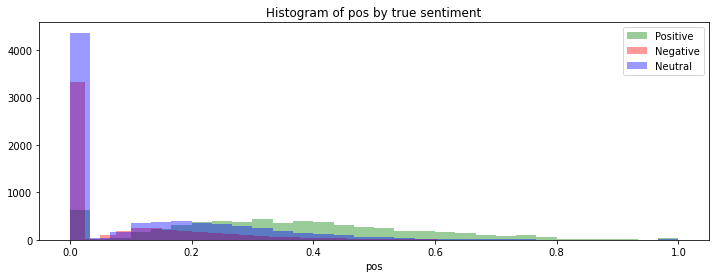

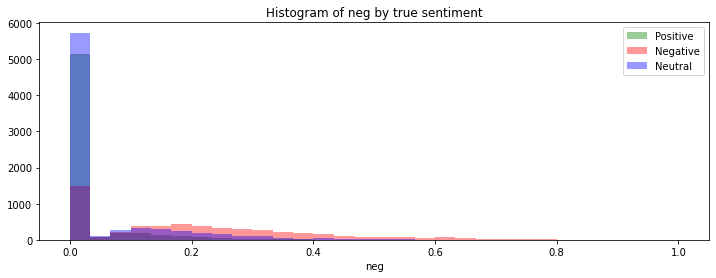

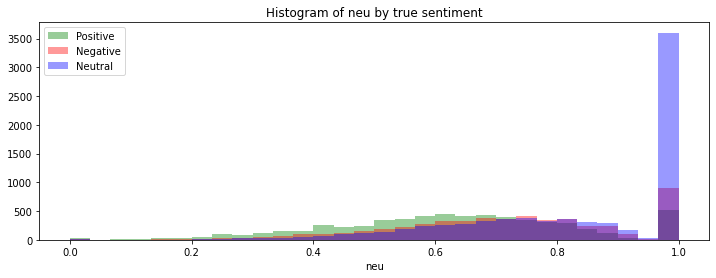

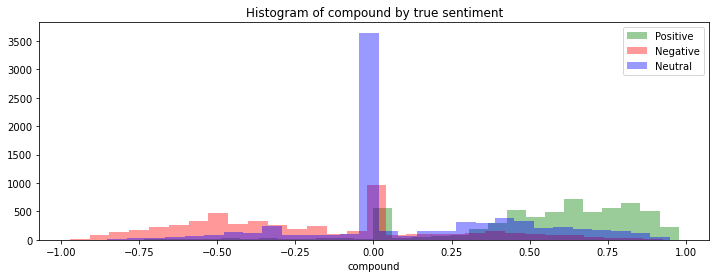

In [81]:
for var in ['pos', 'neg', 'neu', 'compound']:
    plt.figure(figsize=(12,4))
    sns.distplot(essai[(y_train==1)['sentiment']][var], bins=30, kde=False, 
                 color='green', label='Positive')
    sns.distplot(essai[(y_train==-1)['sentiment']][var], bins=30, kde=False, 
                 color='red', label='Negative')
    sns.distplot(essai[(y_train==0)['sentiment']][var], bins=30, kde=False, 
                 color='blue', label='Neutral')
    plt.legend()
    plt.title(f'Histogram of {var} by true sentiment');

Les valeurs importantes de chaque indicateur est bien corrélé avec les éléments sensés être capturés. On peut donc utiliser ces indicateurs dans la modélisation.

### TextBlob

In [83]:
TextBlob(X_train['text'][1]).sentiment

Sentiment(polarity=-0.9765625, subjectivity=1.0)

In [101]:
class Blob(BaseEstimator, TransformerMixin):
    def __init__(self, field):
        self.field = field
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X[['polarity', 'subjectivity']] =  X[self.field].apply(lambda x:TextBlob(x).sentiment).apply(pd.Series)
        return X[['polarity', 'subjectivity']]

In [102]:
blob_pipe=Pipeline([
                     ('blob', Blob(field='text'))
                    ])

In [103]:
essaiB=blob_pipe.transform(X_train)
essaiB.head()

,polarity,subjectivity
0,0.000000,0.0
1,-0.976562,1.0
2,0.000000,0.0
3,0.000000,0.0
4,0.000000,0.0


In [104]:
essaiB.tail()

,polarity,subjectivity
19231,0.875,0.6
19232,0.350,0.3
19233,0.000,0.0
19234,0.000,0.0
19235,-0.500,1.0


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

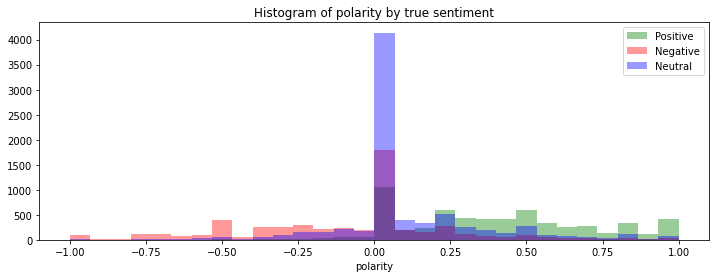

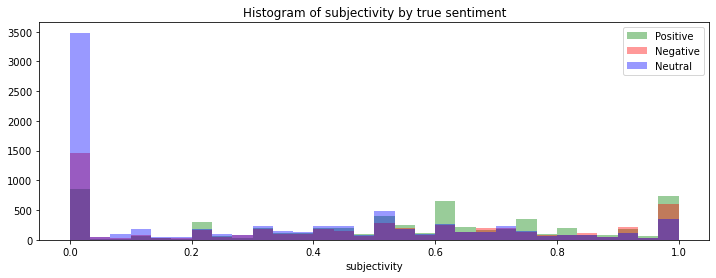

In [105]:
for var in ['polarity', 'subjectivity']:
    plt.figure(figsize=(12,4))
    sns.distplot(essaiB[(y_train==1)['sentiment']][var], bins=30, kde=False, 
                 color='green', label='Positive')
    sns.distplot(essaiB[(y_train==-1)['sentiment']][var], bins=30, kde=False, 
                 color='red', label='Negative')
    sns.distplot(essaiB[(y_train==0)['sentiment']][var], bins=30, kde=False, 
                 color='blue', label='Neutral')
    plt.legend()
    plt.title(f'Histogram of {var} by true sentiment');

### Bag of Words avec Random Forest

In [24]:
bow_pipeline = Pipeline(
    steps=[
        ('coltext', TextSelector('text')), #Sélection de la colonne à transformer (corpus)
        ("tfidf", TfidfVectorizer()),
        ("classifier", RandomForestClassifier(n_jobs=-1)),
    ]
)


In [95]:
list(bow_pipeline.get_params().keys())

['memory',
 'steps',
 'verbose',
 'colext',
 'tfidf',
 'classifier',
 'colext__field',
 'tfidf__analyzer',
 'tfidf__binary',
 'tfidf__decode_error',
 'tfidf__dtype',
 'tfidf__encoding',
 'tfidf__input',
 'tfidf__lowercase',
 'tfidf__max_df',
 'tfidf__max_features',
 'tfidf__min_df',
 'tfidf__ngram_range',
 'tfidf__norm',
 'tfidf__preprocessor',
 'tfidf__smooth_idf',
 'tfidf__stop_words',
 'tfidf__strip_accents',
 'tfidf__sublinear_tf',
 'tfidf__token_pattern',
 'tfidf__tokenizer',
 'tfidf__use_idf',
 'tfidf__vocabulary',
 'classifier__bootstrap',
 'classifier__ccp_alpha',
 'classifier__class_weight',
 'classifier__criterion',
 'classifier__max_depth',
 'classifier__max_features',
 'classifier__max_leaf_nodes',
 'classifier__max_samples',
 'classifier__min_impurity_decrease',
 'classifier__min_impurity_split',
 'classifier__min_samples_leaf',
 'classifier__min_samples_split',
 'classifier__min_weight_fraction_leaf',
 'classifier__n_estimators',
 'classifier__n_jobs',
 'classifier__oob_s

In [98]:
trainPipelineMlFlow(xpName="Bag Of Words - RF", pipeline=bow_pipeline, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, fixed_params={'classifier__random_state':42})

Bag Of Words - RF
params:
  f1_test: 0.6890103140898974
  CR_test:               precision    recall  f1-score   support

          -1       0.74      0.55      0.64      1001
           0       0.61      0.79      0.69      1430
           1       0.80      0.69      0.74      1103

    accuracy                           0.69      3534
   macro avg       0.72      0.68      0.69      3534
weighted avg       0.71      0.69      0.69      3534

elapsed time : 0:00:17.762950


In [120]:
' '.join(list(bow_pipeline.get_params().keys()))

'memory steps verbose colext tfidf classifier colext__field tfidf__analyzer tfidf__binary tfidf__decode_error tfidf__dtype tfidf__encoding tfidf__input tfidf__lowercase tfidf__max_df tfidf__max_features tfidf__min_df tfidf__ngram_range tfidf__norm tfidf__preprocessor tfidf__smooth_idf tfidf__stop_words tfidf__strip_accents tfidf__sublinear_tf tfidf__token_pattern tfidf__tokenizer tfidf__use_idf tfidf__vocabulary classifier__bootstrap classifier__ccp_alpha classifier__class_weight classifier__criterion classifier__max_depth classifier__max_features classifier__max_leaf_nodes classifier__max_samples classifier__min_impurity_decrease classifier__min_impurity_split classifier__min_samples_leaf classifier__min_samples_split classifier__min_weight_fraction_leaf classifier__n_estimators classifier__n_jobs classifier__oob_score classifier__random_state classifier__verbose classifier__warm_start'

In [132]:
re.findall(r"[a-zA-Z\_]+_random_state", ' '.join(list(bow_pipeline.get_params().keys())))

['classifier__random_state']

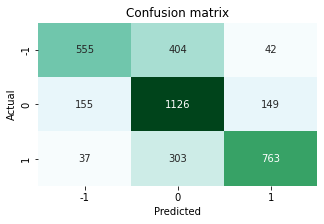

In [151]:
plot_cm(y_test, bow_pipeline.predict(X_test))

### Bag of Words avec Random Forest - Optimisé

In [91]:
params = {
    "tfidf__use_idf": [True, False],
    "tfidf__ngram_range": [(1, 1), (1, 2)],
    "classifier__bootstrap": [True, False],
    "classifier__class_weight": ["balanced", None],
    "classifier__n_estimators": [100, 300, 500, 800, 1200],
    "classifier__max_depth": [5, 8, 15, 25, 30],
    "classifier__min_samples_split": [2, 5, 10, 15, 100],
    "classifier__min_samples_leaf": [1, 2, 5, 10]
}

trainPipelineMlFlow(xpName="Bag Of Words - RF - Opti", pipeline=bow_pipeline, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, fixed_params={'classifier__random_state':42}, opti=True, iterable_params=params)

Bag Of Words - Opti
params:
  f1_test: 0.694338360350514
  CR_test:               precision    recall  f1-score   support

          -1       0.67      0.69      0.68      1001
           0       0.66      0.67      0.66      1430
           1       0.75      0.72      0.74      1103

    accuracy                           0.69      3534
   macro avg       0.70      0.69      0.69      3534
weighted avg       0.69      0.69      0.69      3534

elapsed time : 0:03:31.399667


### Bag of Words avec SVC

In [99]:
bow_pipeline_SVC = Pipeline(
    steps=[
        ('coltext', TextSelector('text')), #Sélection de la colonne à transformer (corpus)
        ("tfidf", TfidfVectorizer()),
        ("classifier", LinearSVC()),
    ]
)

In [100]:
list(bow_pipeline_SVC.get_params().keys())

['memory',
 'steps',
 'verbose',
 'colext',
 'tfidf',
 'classifier',
 'colext__field',
 'tfidf__analyzer',
 'tfidf__binary',
 'tfidf__decode_error',
 'tfidf__dtype',
 'tfidf__encoding',
 'tfidf__input',
 'tfidf__lowercase',
 'tfidf__max_df',
 'tfidf__max_features',
 'tfidf__min_df',
 'tfidf__ngram_range',
 'tfidf__norm',
 'tfidf__preprocessor',
 'tfidf__smooth_idf',
 'tfidf__stop_words',
 'tfidf__strip_accents',
 'tfidf__sublinear_tf',
 'tfidf__token_pattern',
 'tfidf__tokenizer',
 'tfidf__use_idf',
 'tfidf__vocabulary',
 'classifier__C',
 'classifier__class_weight',
 'classifier__dual',
 'classifier__fit_intercept',
 'classifier__intercept_scaling',
 'classifier__loss',
 'classifier__max_iter',
 'classifier__multi_class',
 'classifier__penalty',
 'classifier__random_state',
 'classifier__tol',
 'classifier__verbose']

In [101]:
trainPipelineMlFlow(xpName="Bag Of Words - SVC", pipeline=bow_pipeline_SVC, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, fixed_params={'classifier__random_state':42})

Bag Of Words - SVC
params:
  f1_test: 0.6873879020805563
  CR_test:               precision    recall  f1-score   support

          -1       0.67      0.67      0.67      1001
           0       0.64      0.66      0.65      1430
           1       0.76      0.73      0.74      1103

    accuracy                           0.68      3534
   macro avg       0.69      0.69      0.69      3534
weighted avg       0.69      0.68      0.68      3534

elapsed time : 0:00:01.348530


### Bag of Words avec régression logistique

In [105]:
bow_pipeline_LR = Pipeline(
    steps=[
        ('coltext', TextSelector('text')), #Sélection de la colonne à transformer (corpus)
        ("tfidf", TfidfVectorizer()),
        ("classifier", LogisticRegression(solver='liblinear', multi_class='auto')),
    ]
)

In [106]:
list(bow_pipeline_LR.get_params().keys())

['memory',
 'steps',
 'verbose',
 'colext',
 'tfidf',
 'classifier',
 'colext__field',
 'tfidf__analyzer',
 'tfidf__binary',
 'tfidf__decode_error',
 'tfidf__dtype',
 'tfidf__encoding',
 'tfidf__input',
 'tfidf__lowercase',
 'tfidf__max_df',
 'tfidf__max_features',
 'tfidf__min_df',
 'tfidf__ngram_range',
 'tfidf__norm',
 'tfidf__preprocessor',
 'tfidf__smooth_idf',
 'tfidf__stop_words',
 'tfidf__strip_accents',
 'tfidf__sublinear_tf',
 'tfidf__token_pattern',
 'tfidf__tokenizer',
 'tfidf__use_idf',
 'tfidf__vocabulary',
 'classifier__C',
 'classifier__class_weight',
 'classifier__dual',
 'classifier__fit_intercept',
 'classifier__intercept_scaling',
 'classifier__l1_ratio',
 'classifier__max_iter',
 'classifier__multi_class',
 'classifier__n_jobs',
 'classifier__penalty',
 'classifier__random_state',
 'classifier__solver',
 'classifier__tol',
 'classifier__verbose',
 'classifier__warm_start']

In [107]:
trainPipelineMlFlow(xpName="Bag Of Words - LR", pipeline=bow_pipeline_LR, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, fixed_params={'classifier__random_state':42})

Bag Of Words - LR
params:
  f1_test: 0.7101946029434797
  CR_test:               precision    recall  f1-score   support

          -1       0.74      0.64      0.68      1001
           0       0.64      0.76      0.70      1430
           1       0.80      0.71      0.75      1103

    accuracy                           0.71      3534
   macro avg       0.73      0.70      0.71      3534
weighted avg       0.72      0.71      0.71      3534

elapsed time : 0:00:01.901032


## Bag of Words avec régression logistique - tokenizer

In [39]:
def tokenize(text):
    tknzr = nltk.casual.TweetTokenizer(strip_handles=True, reduce_len=True)
    tokens = tknzr.tokenize(str(text))
    stems = []
    for item in tokens:
        stems.append(item)
    return stems

In [40]:
bow_pipeline_LR = Pipeline(
    steps=[
        ('coltext', TextSelector('text')), #Sélection de la colonne à transformer (corpus)
        ("tfidf", TfidfVectorizer()),
        ("classifier", LogisticRegression(solver='liblinear', multi_class='auto')),
    ]
)

In [155]:
params = {
    "tfidf__use_idf": [True, False],
    "tfidf__ngram_range": [(1, 1), (1, 2), (1, 3), (1, 4)],
    "tfidf__tokenizer":[None, tokenize]
}

In [41]:
list(bow_pipeline_LR.get_params().keys())

['memory',
 'steps',
 'verbose',
 'coltext',
 'tfidf',
 'classifier',
 'coltext__field',
 'tfidf__analyzer',
 'tfidf__binary',
 'tfidf__decode_error',
 'tfidf__dtype',
 'tfidf__encoding',
 'tfidf__input',
 'tfidf__lowercase',
 'tfidf__max_df',
 'tfidf__max_features',
 'tfidf__min_df',
 'tfidf__ngram_range',
 'tfidf__norm',
 'tfidf__preprocessor',
 'tfidf__smooth_idf',
 'tfidf__stop_words',
 'tfidf__strip_accents',
 'tfidf__sublinear_tf',
 'tfidf__token_pattern',
 'tfidf__tokenizer',
 'tfidf__use_idf',
 'tfidf__vocabulary',
 'classifier__C',
 'classifier__class_weight',
 'classifier__dual',
 'classifier__fit_intercept',
 'classifier__intercept_scaling',
 'classifier__l1_ratio',
 'classifier__max_iter',
 'classifier__multi_class',
 'classifier__n_jobs',
 'classifier__penalty',
 'classifier__random_state',
 'classifier__solver',
 'classifier__tol',
 'classifier__verbose',
 'classifier__warm_start']

In [156]:
trainPipelineMlFlow(xpName="Bag Of Words - LR - TweetToken", pipeline=bow_pipeline_LR, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, fixed_params={'classifier__random_state':42, 'tfidf__tokenizer':tokenize, 'classifier__n_jobs':-1}, opti=True, iterable_params=params)

Bag Of Words - LR - TweetToken
params:
  f1_test: 0.6889274802509372
  CR_test:               precision    recall  f1-score   support

          -1       0.72      0.58      0.64      1001
           0       0.63      0.74      0.68      1430
           1       0.76      0.73      0.74      1103

    accuracy                           0.69      3534
   macro avg       0.70      0.68      0.69      3534
weighted avg       0.70      0.69      0.69      3534

elapsed time : 0:03:07.053232


In [49]:
import shap
import transformers

In [69]:
X_train.head()

,textID,text,selected_text
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going"
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD
2,088c60f138,my boss is bullying me...,bullying me
3,9642c003ef,what interview! leave me alone,leave me alone
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,"


In [56]:
explainer = shap.Explainer(bow_pipeline_LR.predict_proba)

In [64]:
explainer = shap.Explainer(bow_pipeline_LR.predict_proba,tokenize,output_names=['negative', 'neutral', 'positive'])

In [83]:
explainer = shap.LinearExplainer(bow_pipeline_LR.named_steps['classifier'].predict_proba, bow_pipeline_LR.named_steps['tfidf'].transform(X_train['text']))

Exception: An unknown model type was passed: <class 'method'>

In [82]:
shap_values = explainer(bow_pipeline_LR.named_steps['tfidf'].transform(X_train['text']))

Exception: The passed data does not match the background shape expected by the masker! The data of shape (1, 21307) was passed while the masker expected data of shape (21307,).

In [81]:
bow_pipeline_LR.named_steps['tfidf'].transform(X_train['text'])[0:3]

<3x21307 sparse matrix of type '<class 'numpy.float64'>'
	with 14 stored elements in Compressed Sparse Row format>

In [60]:
bow_pipeline_LR.predict_proba(X_train[0:2])

array([[0.1440611 , 0.68602382, 0.16991508],
       [0.91107286, 0.06678813, 0.02213901]])

In [84]:
def pred_fcn(x, pipe=bow_pipeline_LR):
    return pipe.predict_proba(pipe.transform(x))


In [93]:
lr_explainer = shap.Explainer(pred_fcn, X_train)

In [94]:
shap_values = lr_explainer(X_train['text'][0:3])

AttributeError: 'str' object has no attribute 'shape'

In [95]:
from wordcloud import WordCloud

In [98]:
X_train['text'][y_train['sentiment']==1]

6        2am feedings for the baby are fun when he is a...
9         Journey!? Wow... u just became cooler.  hehe....
11       I really really like the song Love Story by Ta...
21       Playing Ghost Online is really interesting. Th...
25       the free fillin` app on my ipod is fun, im add...
                               ...                        
19224     Awww you`ll have to post a pic  I bet it`ll l...
19227                  Ta very much!  Happy B-Day to G-son
19229     haha what can i say, you`re a great teacher!!...
19231                  Good to see you hear as well, Andy!
19232                                 wants to feel better
Name: text, Length: 6080, dtype: object

In [109]:
trainPositif = ' '.join(tweet for tweet in X_train['text'][y_train['sentiment']==1])

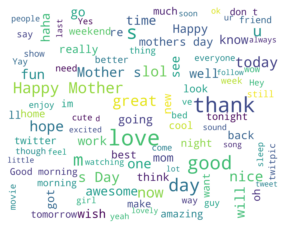

In [112]:
wc = WordCloud(
    stopwords=None,
    max_font_size=200,
    width=2500,
    height=2000,
    max_words=100,
    random_state=44,
    background_color="white").generate(trainPositif)
plt.figure()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [114]:
bow_pipeline_LR.predict(X_train)==1

array([False, False, False, ..., False, False, False])

In [115]:
trainFauxPositifNeutral = ' '.join(tweet for tweet in X_train['text'][(y_train['sentiment']==0) & (bow_pipeline_LR.predict(X_train)==1)])

In [116]:
def plotWc(text):
    wc = WordCloud(
    stopwords=None,
    max_font_size=200,
    width=2500,
    height=2000,
    max_words=100,
    random_state=44,
    background_color="white").generate(text)
    plt.figure()
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    

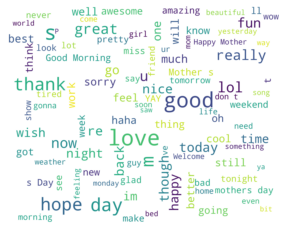

In [117]:
plotWc(trainFauxPositifNeutral)

In [118]:
X_train['text'][(y_train['sentiment']==0) & (bow_pipeline_LR.predict(X_train)==1)].head()

10     as much as i love to be hopeful, i reckon the...
20     oh Marly, I`m so sorry!!  I hope you find her...
40     Car not happy, big big dent in boot! Hoping t...
59                        what fun are you speaking of?
74     she is good! so gor-juz yea i kno i asked her...
Name: text, dtype: object

In [119]:
trainFauxNegatifNeutral = ' '.join(tweet for tweet in X_train['text'][(y_train['sentiment']==0) & (bow_pipeline_LR.predict(X_train)==-1)])

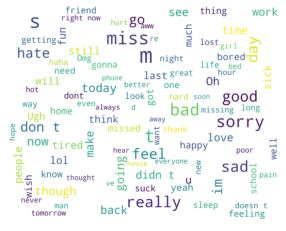

In [120]:
plotWc(trainFauxNegatifNeutral)

In [123]:
X_test['text'][(y_test['sentiment']==0) & (bow_pipeline_LR.predict(X_test)==-1)]

23                                   about to go to sleep
32      There is a faux gothy chick looking at me, sor...
37      So I really need to put the laptop down & star...
46      i miss my old phone it worked so good until i ...
67                     Terminator Salvation... by myself.
                              ...                        
3467                     Oh It was marathon ****? mahasha
3472          have fun!  i am sad to not be with you guys
3477    _Ellen and she`s 9.5 and a rescue.. bad hips. ...
3487                     Bored, making a mothers day card
3517    On a 10min brake. At wrrkk ... its 11:06 and i...
Name: text, Length: 186, dtype: object

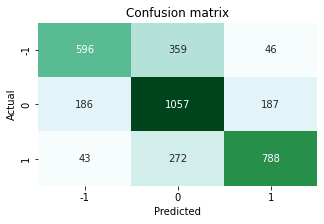

In [121]:
plot_cm(y_test, bow_pipeline_LR.predict(X_test))

In [125]:
!pip install lime

     |████████████████████████████████| 275 kB 8.9 MB/s eta 0:00:01
     |████████████████████████████████| 30.2 MB 26.1 MB/s eta 0:00:01
     |████████████████████████████████| 3.3 MB 86.6 MB/s eta 0:00:01
     |████████████████████████████████| 165 kB 70.9 MB/s eta 0:00:01
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283845 sha256=74a5c2ca0854f96cd3c00cf409e37eb21a2d90cd3c7d862987051309a51718d4
  Stored in directory: /root/.cache/pip/wheels/e6/a6/20/cc1e293fcdb67ede666fed293cb895395e7ecceb4467779546
Successfully built lime


In [126]:
import lime

In [127]:
from lime import lime_text

In [128]:
from lime.lime_text import LimeTextExplainer

In [129]:
explainer = LimeTextExplainer(class_names=['negative', 'neutral','positive'])

In [130]:
idx = 23

In [132]:
X_test['text'][idx]

'about to go to sleep'

In [142]:
exp = explainer.explain_instance(X_test.iloc[[idx]], bow_pipeline_LR.predict_proba, num_features=3, top_labels=2)

TypeError: expected string or bytes-like object

In [139]:
X_test.iloc[[idx]]

,textID,text
23,f0ef04109b,about to go to sleep


In [141]:
print(bow_pipeline_LR.predict_proba(X_test.iloc[[idx]]))

[[0.44811558 0.3911781  0.16070632]]


c'est a priori un pb de format. LIME attend du text

In [143]:
def essai(text):
    df=pd.DataFrame(text, columns=['text'])
    res= bow_pipeline_LR.predict_proba(df)
    return res

In [144]:
exp = explainer.explain_instance(X_test['text'][idx], essai, num_features=3, top_labels=2)

In [146]:
exp.show_in_notebook(text=X_test['text'][idx], labels=(0,))

### Essai SHAP

In [154]:
explainer = shap.Explainer(essai, tokenizer=tokenize,output_names=['negative','neutral','positive'])

TypeError: __init__() got an unexpected keyword argument 'tokenizer'

In [153]:
shap_values = explainer(X_test['text'][0:50])

TypeError: explain_row() got an unexpected keyword argument 'tokenizer'

In [149]:
tokenize()

['0',
 'Last',
 'session',
 'of',
 'the',
 'day',
 'http://twitpic.com/67ezh',
 '1',
 'Shanghai',
 'is',
 'also',
 'really',
 'exciting',
 '(',
 'precisely',
 '-',
 '...',
 '2',
 'Recession',
 'hit',
 'Veronique',
 'Branquinho',
 ',',
 'she',
 'has',
 'to',
 '...',
 '3',
 'happy',
 'bday',
 '!',
 '4',
 'http://twitpic.com/4w75p',
 '-',
 'I',
 'like',
 'it',
 '!',
 '!',
 '5',
 'that',
 '`',
 's',
 'great',
 '!',
 '!',
 'weee',
 '!',
 '!',
 'visitors',
 '!',
 '6',
 'I',
 'THINK',
 'EVERYONE',
 'HATES',
 'ME',
 'ON',
 'HERE',
 'lol',
 '7',
 'sooo',
 'wish',
 'i',
 'could',
 ',',
 'but',
 'im',
 'in',
 'school',
 'and',
 'my',
 '...',
 '8',
 'and',
 'within',
 'a',
 'short',
 'time',
 'of',
 'the',
 'last',
 'clue',
 'all',
 '...',
 '9',
 'What',
 'did',
 'you',
 'get',
 '?',
 'My',
 'day',
 'is',
 'alright',
 '..',
 'haven',
 '`',
 '...',
 '10',
 'My',
 'bike',
 'was',
 'put',
 'on',
 'hold',
 '...',
 'should',
 'have',
 'known',
 'th',
 '...',
 '11',
 'I',
 'checked',
 '.',
 'We',
 'didn

### Bag of Words avec XGB

In [83]:
bow_pipeline_xgb = Pipeline([
    ('features', FeatureUnion([
        ('text', Pipeline([
            ('coltext', TextSelector('text')), #Sélection de la colonne à transformer (corpus)
            ('tfidf', TfidfVectorizer(tokenizer=Tokenizer, stop_words=stopwords.words('english'), #Sélection de la colonne à transformer (corpus)
                     min_df=.0025, max_df=0.25, ngram_range=(1,3))),
            ('svd', TruncatedSVD(algorithm='randomized', n_components=300)), #for XGB : linear dimensionality reduction by means of truncated singular value decomposition (SVD)
        ]))
    ])),
    ('clf', XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.1)),
#    ('clf', RandomForestClassifier()),
    ])

In [153]:
random_state_params(bow_pipeline_xgb, random_state)

{'features__text__svd__random_state': 42, 'clf__random_state': 42}

In [141]:
pipe = bow_pipeline_LR
display(pd.DataFrame(pipe.transform(X_train), columns=pipe['tfidf'].get_feature_names(X_train.columns)).head())

AttributeError: 'LogisticRegression' object has no attribute 'transform'

In [154]:
trainPipelineMlFlow(xpName="Bag Of Words_XGB", 
                    pipeline=bow_pipeline_xgb, 
                    X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, 
                    fixed_params=random_state_params(bow_pipeline_xgb, random_state)
                   )

[13:42:12] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Bag Of Words_XGB
params:
  f1_test: 0.6570162011710532
  CR_test:               precision    recall  f1-score   support

          -1       0.73      0.49      0.59      1001
           0       0.59      0.79      0.67      1430
           1       0.77      0.66      0.71      1103

    accuracy                           0.66      3534
   macro avg       0.70      0.65      0.66      3534
weighted avg       0.69      0.66      0.66      3534

elapsed time : 0:03:43.247039


### Word2Vec avec spaCy - en_core_web_md

Les modèles word2vec spaCy sont pré entrainés et disponibles [ici](https://spacy.io/models/en#en_core_web_md)

**ATTENTION** : à regarder [page](https://www.dataquest.io/blog/tutorial-text-classification-in-python-using-spacy/)

https://stackabuse.com/python-for-nlp-sentiment-analysis-with-scikit-learn/

In [63]:
import spacy

In [65]:
nlp = spacy.load("en_core_web_md")  # this model will give you 300D
#nlp = spacy.load("en_core_web_trf")

In [66]:
class SpacyVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, nlp):
        self.nlp = nlp
        self.dim = 300

    def fit(self, X, y):
        return self

    def transform(self, X):
        # Doc.vector defaults to an average of the token vectors.
        # https://spacy.io/api/doc#vector
        return [self.nlp(text).vector for text in X]

In [68]:
embeddings_pipeline = Pipeline(
    steps=[
        ('coltext', TextSelector('text')), #Sélection de la colonne à transformer (corpus)
        ("mean_embeddings", SpacyVectorTransformer(nlp)),
        ("reduce_dim", TruncatedSVD(50)),
        ("classifier", RandomForestClassifier(n_jobs=-1)),
    ]
)

In [111]:
list(embeddings_pipeline.get_params().keys())

['memory',
 'steps',
 'verbose',
 'colext',
 'mean_embeddings',
 'reduce_dim',
 'classifier',
 'colext__field',
 'mean_embeddings__nlp',
 'reduce_dim__algorithm',
 'reduce_dim__n_components',
 'reduce_dim__n_iter',
 'reduce_dim__random_state',
 'reduce_dim__tol',
 'classifier__bootstrap',
 'classifier__ccp_alpha',
 'classifier__class_weight',
 'classifier__criterion',
 'classifier__max_depth',
 'classifier__max_features',
 'classifier__max_leaf_nodes',
 'classifier__max_samples',
 'classifier__min_impurity_decrease',
 'classifier__min_impurity_split',
 'classifier__min_samples_leaf',
 'classifier__min_samples_split',
 'classifier__min_weight_fraction_leaf',
 'classifier__n_estimators',
 'classifier__n_jobs',
 'classifier__oob_score',
 'classifier__random_state',
 'classifier__verbose',
 'classifier__warm_start']

In [82]:
trainPipelineMlFlow(xpName="Word2Vec - spaCy - en_core_web_md", pipeline=embeddings_pipeline, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, fixed_params={'reduce_dim__random_state':42,'classifier__random_state':42})

Word2Vec - spaCy - en_core_web_md
params:
  f1_test: 0.5940309137680513
  CR_test:               precision    recall  f1-score   support

          -1       0.63      0.47      0.54      1001
           0       0.54      0.74      0.63      1430
           1       0.71      0.55      0.62      1103

    accuracy                           0.60      3534
   macro avg       0.63      0.58      0.59      3534
weighted avg       0.62      0.60      0.60      3534

elapsed time : 0:03:34.784784
